In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')

data = data[:, 1:]

dataNorm = data / np.max(data)
dataNorm = 2*dataNorm - 1

data = torch.tensor(dataNorm).float()

batchsize = 100

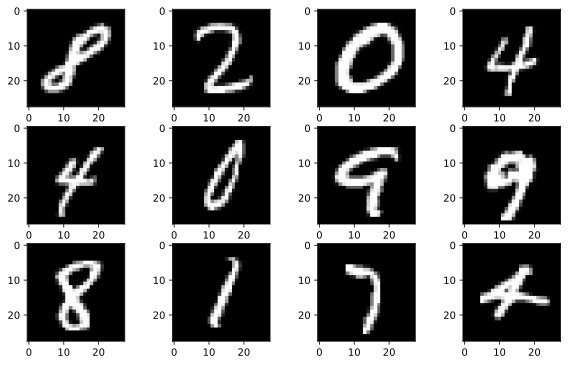

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(10, 6))

for ax in axs.flatten():
  randimg2show = np.random.randint(0, high = data.shape[0])
  img = np.reshape(data[randimg2show, :], (28, 28))
  ax.imshow(img, cmap='gray')

In [ ]:
class discriminator(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False)
    self.conv4 = nn.Conv2d(256, 1, kernel_size=4, stride=2, padding=1, bias=False)

    self.bnorm2 = nn.BatchNorm2d(128)
    self.bnorm3 = nn.BatchNorm2d(256)

  def forward(self, x):

    x = F.leaky_relu(self.conv1(x), 0.2)

    x = F.leaky_relu(self.conv2(x), 0.2)
    x = self.bnorm2(x)

    x = F.leaky_relu(self.conv3(x), 0.2)
    x = self.bnorm3(x)

    x = self.conv4(x)

    return torch.sigmoid(x).view(-1, 1)

dnet = discriminator()
dnet(torch.randn((10, 1, 28, 28)))

tensor([[0.3367],
        [0.7091],
        [0.4365],
        [0.4878],
        [0.4287],
        [0.7437],
        [0.3968],
        [0.5079],
        [0.4554],
        [0.5683]], grad_fn=<ViewBackward0>)

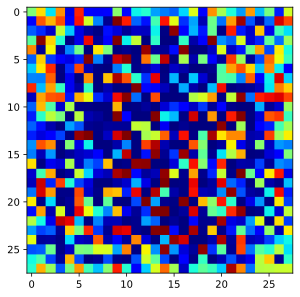

In [ ]:
class generator(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.ConvTranspose2d(100, 256, 5, 2, 1, bias=False)
    self.conv2 = nn.ConvTranspose2d(256, 128, 5, 2, 1, bias=False)
    self.conv3 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
    self.conv4 = nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False)

    self.bnorm1 = nn.BatchNorm2d(256)
    self.bnorm2 = nn.BatchNorm2d(128)
    self.bnorm3 = nn.BatchNorm2d(64)

  def forward(self, x):

    x = F.leaky_relu(self.bnorm1(self.conv1(x)), 0.2)

    x = F.leaky_relu(self.bnorm2(self.conv2(x)), 0.2)

    x = F.leaky_relu(self.bnorm3(self.conv3(x)), 0.2)

    x = self.conv4(x)

    return torch.tanh(x)

gnet = generator()
y = gnet(torch.randn((10, 100, 1, 1)))
plt.imshow(y.detach()[0,:,:,:].permute((1,2,0)), cmap='jet')
plt.show()

In [ ]:
loss_fn = nn.BCELoss()

gnet = generator().to(device)
dnet = discriminator().to(device)

d_optimiser = torch.optim.Adam(dnet.parameters(), lr=0.0003)
g_optimiser = torch.optim.Adam(gnet.parameters(), lr=0.0003)

In [ ]:
epoches = 50000
batchSize = 20

losses = np.zeros((epoches, 2))
discriminator_decesion = np.zeros((epoches, 2))

for epoch in range(epoches):

  random_index = torch.randint(data.shape[0], (batchSize, ))
  real_images = data[random_index].view(batchSize,1, 28,28).to(device)
  fake_images = gnet(torch.randn((batchSize, 100, 1, 1)).to(device))

  real_labels = torch.ones((batchSize, 1)).to(device)
  fake_labels = torch.zeros((batchSize, 1)).to(device)

  y_real = dnet(real_images)
  loss_real_disc = loss_fn(y_real, real_labels)

  y_fake = dnet(fake_images)
  loss_fake_disc = loss_fn(y_fake, fake_labels)

  loss_disc = loss_fake_disc + loss_real_disc
  losses[epoch, 0] = loss_disc.item()
  discriminator_decesion[epoch, 0] = torch.mean((y_real>0.5).float()).detach()

  d_optimiser.zero_grad()
  loss_disc.backward()
  d_optimiser.step()

  fake_images = gnet(torch.randn((batchSize, 100, 1, 1)).to(device))
  y_fake = dnet(fake_images)

  loss_generator = loss_fn(y_fake, real_labels)
  losses[epoch, 1] = loss_generator.item()
  discriminator_decesion[epoch, 1] = torch.mean((y_fake>0.5).float()).detach()

  g_optimiser.zero_grad()
  loss_generator.backward()
  g_optimiser.step()

  if(epoch+1)%100 == 0:
    sys.stdout.write('\r' + "Epoch No ->> " + str(epoch+1))

Epoch No ->> 50000

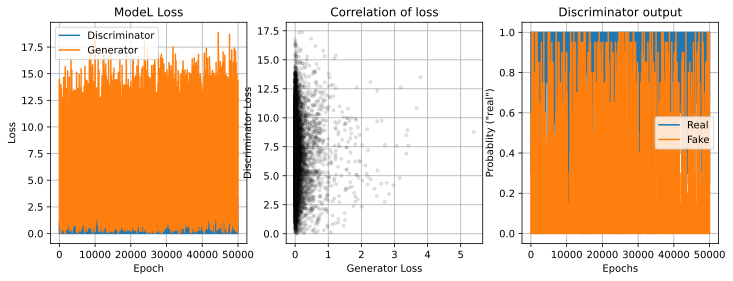

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

ax[0].plot(losses)
ax[0].legend(['Discriminator', 'Generator'])
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("ModeL Loss")
ax[0].grid()
# ax[0].set_ylim([1,2])


ax[1].plot(losses[::5,0], losses[::5,1], 'k.', alpha=0.1)
ax[1].set_ylabel("Discriminator Loss")
ax[1].set_xlabel("Generator Loss")
ax[1].set_title("Correlation of loss")
ax[1].grid()


ax[2].plot(discriminator_decesion)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])
ax[2].grid()

plt.show()

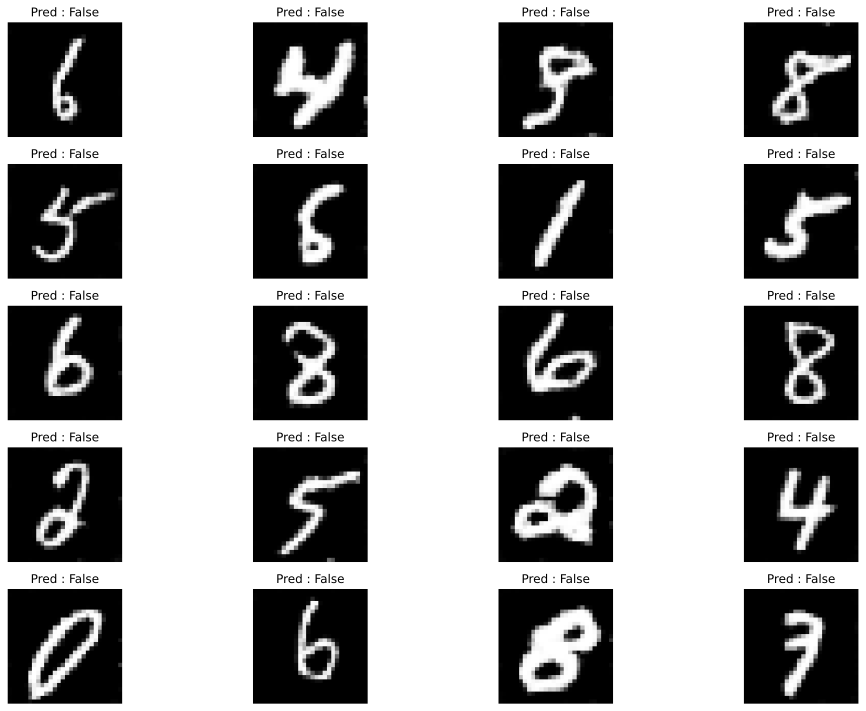

In [ ]:
gnet.eval()
fake_data = gnet(torch.randn(20,100,1,1).to(device)).cpu()


fig,axs = plt.subplots(5,4,figsize=(15,10))
for i,ax in enumerate(axs.flatten()):
    lets_see = dnet(fake_data[i:i+1].to(device)).detach().item() > 0.5

    # cmp = 'gray' if lets_see else 'hot'
    ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
    ax.set_title(f"Pred : {lets_see}")
    ax.axis('off')

plt.tight_layout()
plt.show()